In [1]:
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('sample_submission.csv')
df = pd.concat([train, test], sort=False)


In [4]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [5]:
df.shape

(958000, 5)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [7]:
train.describe().T

count       mean        std  min   25%   50%   75%    max
store  913000.0   5.500000   2.872283  1.0   3.0   5.5   8.0   10.0
item   913000.0  25.500000  14.430878  1.0  13.0  25.5  38.0   50.0
sales  913000.0  52.250287  28.801144  0.0  30.0  47.0  70.0  231.0

In [8]:
train.describe([0.05,0.01,0.25,0.50,0.75,0.80,0.90,0.95,0.99]).T

count       mean        std  min    1%    5%   25%   50%   75%   80%   90%    95%    99%    max
store  913000.0   5.500000   2.872283  1.0   1.0   1.0   3.0   5.5   8.0   8.2   9.1   10.0   10.0   10.0
item   913000.0  25.500000  14.430878  1.0   1.0   3.0  13.0  25.5  38.0  40.2  45.1   48.0   50.0   50.0
sales  913000.0  52.250287  28.801144  0.0  10.0  16.0  30.0  47.0  70.0  76.0  93.0  107.0  135.0  231.0

In [9]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


In [11]:
test.describe().T

count     mean           std  min       25%      50%       75%      max
id     45000.0  22499.5  12990.525394  0.0  11249.75  22499.5  33749.25  44999.0
store  45000.0      5.5      2.872313  1.0      3.00      5.5      8.00     10.0
item   45000.0     25.5     14.431030  1.0     13.00     25.5     38.00     50.0

In [12]:
test.describe([0.05,0.01,0.25,0.50,0.75,0.80,0.90,0.95,0.99]).T

count     mean           std  min      1%       5%       25%      50%       75%      80%      90%       95%       99%      max
id     45000.0  22499.5  12990.525394  0.0  449.99  2249.95  11249.75  22499.5  33749.25  35999.2  40499.1  42749.05  44549.01  44999.0
store  45000.0      5.5      2.872313  1.0    1.00     1.00      3.00      5.5      8.00      8.2      9.1     10.00     10.00     10.0
item   45000.0     25.5     14.431030  1.0    1.00     3.00     13.00     25.5     38.00     40.2     45.1     48.00     50.00     50.0

In [13]:
test.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [14]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


In [15]:
sample_sub.describe().T

count     mean           std   min       25%      50%       75%      max
id     45000.0  22499.5  12990.525394   0.0  11249.75  22499.5  33749.25  44999.0
sales  45000.0     52.0      0.000000  52.0     52.00     52.0     52.00     52.0

In [16]:
sample_sub.describe([0.05,0.01,0.25,0.50,0.75,0.80,0.90,0.95,0.99]).T

count     mean           std   min      1%       5%       25%      50%       75%      80%      90%       95%       99%      max
id     45000.0  22499.5  12990.525394   0.0  449.99  2249.95  11249.75  22499.5  33749.25  35999.2  40499.1  42749.05  44549.01  44999.0
sales  45000.0     52.0      0.000000  52.0   52.00    52.00     52.00     52.0     52.00     52.0     52.0     52.00     52.00     52.0

In [17]:
sample_sub.isnull().sum()

id       0
sales    0
dtype: int64

In [18]:
from collections import Counter

In [19]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [20]:
df.loc[detect_outliers(df,["sales"])] #Aykırı değer yok

Empty DataFrame
Columns: [date, store, item, sales, id]
Index: []

In [21]:
df[["store"]].nunique()

store    10
dtype: int64

In [22]:
df[["item"]].nunique()

item    50
dtype: int64

In [23]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [24]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})


sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [25]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

### FEATURE ENGINEERING

In [26]:
df.head()

date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN

In [27]:
df.tail()

date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0

In [28]:
df.shape

(958000, 5)

In [29]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [30]:
df = create_date_features(df)

In [31]:
df.head(20)

date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0  2013-01-01      1     1   13.0 NaN      1             1            1             1            2  2013        0               1             0
1  2013-01-02      1     1   11.0 NaN      1             2            2             1            3  2013        0               0             0
2  2013-01-03      1     1   14.0 NaN      1             3            3             1            4  2013        0               0             0
3  2013-01-04      1     1   13.0 NaN      1             4            4             1            5  2013        1               0             0
4  2013-01-05      1     1   10.0 NaN      1             5            5             1            6  2013        1               0             0
5  2013-01-06      1     1   12.0 NaN      1             6            6             1            7  2013        1               0             0
6  2013-01-07      1     1   10.0 NaN      1             7            7             2            1  2013        0               0             0
7  2013-01-08      1     1    9.0 NaN      1             8            8             2            2  2013        0               0             0
8  2013-01-09      1     1   12.0 NaN      1             9            9             2            3  2013        0               0             0
9  2013-01-10      1     1    9.0 NaN      1            10           10             2            4  2013        0               0             0
10 2013-01-11      1     1    9.0 NaN      1            11           11             2            5  2013        1               0             0
11 2013-01-12      1     1    7.0 NaN      1            12           12             2            6  2013        1               0             0
12 2013-01-13      1     1   10.0 NaN      1            13           13             2            7  2013        1               0             0
13 2013-01-14      1     1   12.0 NaN      1            14           14             3            1  2013        0               0             0
14 2013-01-15      1     1    5.0 NaN      1            15           15             3            2  2013        0               0             0
15 2013-01-16      1     1    7.0 NaN      1            16           16             3            3  2013        0               0             0
16 2013-01-17      1     1   16.0 NaN      1            17           17             3            4  2013        0               0             0
17 2013-01-18      1     1    7.0 NaN      1            18           18             3            5  2013        1               0             0
18 2013-01-19      1     1   18.0 NaN      1            19           19             3            6  2013        1               0             0
19 2013-01-20      1     1   15.0 NaN      1            20           20             3            7  2013        1               0             0

In [32]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [33]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))          #RANDOM NOISE


In [34]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)     #Lag/Shifted Features

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            958000 non-null  datetime64[ns]
 1   store           958000 non-null  int64         
 2   item            958000 non-null  int64         
 3   sales           913000 non-null  float64       
 4   id              45000 non-null   float64       
 5   month           958000 non-null  int64         
 6   day_of_month    958000 non-null  int64         
 7   day_of_year     958000 non-null  int64         
 8   week_of_year    958000 non-null  int64         
 9   day_of_week     958000 non-null  int64         
 10  year            958000 non-null  int64         
 11  is_wknd         958000 non-null  int64         
 12  is_month_start  958000 non-null  int32         
 13  is_month_end    958000 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int

In [36]:
df.describe().T

count          mean           std     min       25%      50%       75%      max
store           958000.0      5.500000      2.872283     1.0      3.00      5.5      8.00     10.0
item            958000.0     25.500000     14.430877     1.0     13.00     25.5     38.00     50.0
sales           913000.0     52.250287     28.801144     0.0     30.00     47.0     70.00    231.0
id               45000.0  22499.500000  12990.525394     0.0  11249.75  22499.5  33749.25  44999.0
month           958000.0      6.311065      3.504592     1.0      3.00      6.0      9.00     12.0
day_of_month    958000.0     15.718685      8.795328     1.0      8.00     16.0     23.00     31.0
day_of_year     958000.0    176.636743    107.105069     1.0     80.00    174.0    270.00    366.0
week_of_year    958000.0     25.691023     15.302475     1.0     12.00     25.0     39.00     53.0
day_of_week     958000.0      4.000000      1.998696     1.0      2.00      4.0      6.00      7.0
year            958000.0   2015.141441      1.519304  2013.0   2014.00   2015.0   2016.00   2018.0
is_wknd         958000.0      0.428497      0.494861     0.0      0.00      0.0      1.00      1.0
is_month_start  958000.0      0.032881      0.178325     0.0      0.00      0.0      0.00      1.0
is_month_end    958000.0      0.032881      0.178325     0.0      0.00      0.0      0.00      1.0

In [37]:
df["sales"].head(10)

0    13.0
1    11.0
2    14.0
3    13.0
4    10.0
5    12.0
6    10.0
7     9.0
8    12.0
9     9.0
Name: sales, dtype: float64

In [38]:
df["sales"].shift(1).values[0:10]

array([nan, 13., 11., 14., 13., 10., 12., 10.,  9., 12.])

In [39]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})


sales  lag1  lag2  lag3  lag4
0   13.0   NaN   NaN   NaN   NaN
1   11.0  13.0   NaN   NaN   NaN
2   14.0  11.0  13.0   NaN   NaN
3   13.0  14.0  11.0  13.0   NaN
4   10.0  13.0  14.0  11.0  13.0
5   12.0  10.0  13.0  14.0  11.0
6   10.0  12.0  10.0  13.0  14.0
7    9.0  10.0  12.0  10.0  13.0
8   12.0   9.0  10.0  12.0  10.0
9    9.0  12.0   9.0  10.0  12.0

In [40]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [41]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [42]:
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [43]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [44]:
df.head()

date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728
0 2013-01-01      1     1   13.0 NaN      1             1            1             1            2  2013        0               1             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN
1 2013-01-02      1     1   11.0 NaN      1             2            2             1            3  2013        0               0             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN
2 2013-01-03      1     1   14.0 NaN      1             3            3             1            4  2013        0               0             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN
3 2013-01-04      1     1   13.0 NaN      1             4            4             1            5  2013        1               0             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN
4 2013-01-05      1     1   10.0 NaN      1             5            5             1            6  2013        1               0             0           NaN           NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN

In [45]:
df[df["sales"].isnull()]

date  store  item  sales       id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728
0     2018-01-01      1     1    NaN      0.0      1             1            1             1            1  2018        0               1             0     12.901119     15.905435      20.674392      16.899667      14.062668      14.457743      18.296764      18.329953      18.675060      13.268977
1     2018-01-02      1     1    NaN      1.0      1             2            2             1            2  2018        0               0             0     16.053651     16.077965      21.792443      20.255811      24.688092      19.252937      24.117760      10.794479      30.901254      13.402766
2     2018-01-03      1     1    NaN      2.0      1             3            3             1            3  2018        0               0             0     14.327199     26.869761      20.430423      10.620368      23.572493      21.971745      24.035971      17.435436      20.923102      15.864738
3     2018-01-04      1     1    NaN      3.0      1             4            4             1            4  2018        0               0             0     19.556062     22.036305      20.107320      25.583914      28.528982      22.872099      30.530930      15.448627      35.041783      10.551563
4     2018-01-05      1     1    NaN      4.0      1             5            5             1            5  2018        1               0             0     15.744342     27.411145      26.757803      26.104353      28.586818      40.648457      32.924963      26.265657      36.187326      11.456140
...          ...    ...   ...    ...      ...    ...           ...          ...           ...          ...   ...      ...             ...           ...           ...           ...            ...            ...            ...            ...            ...            ...            ...            ...
44995 2018-03-27     10    50    NaN  44995.0      3            27           86            13            2  2018        0               0             0     42.213271     53.546575      66.859360      67.740980      68.308069      77.657341      83.480311      59.030569      98.657270      72.197488
44996 2018-03-28     10    50    NaN  44996.0      3            28           87            13            3  2018        0               0             0     59.164028     51.418515      63.857497      58.306995      77.240543      80.985058      81.421659      72.121539      77.494821      68.986064
44997 2018-03-29     10    50    NaN  44997.0      3            29           88            13            4  2018        0               0             0     59.305229     63.356284      74.524333      63.799148      71.482331      84.875539      82.989526      67.496487      98.915976      76.215475
44998 2018-03-30     10    50    NaN  44998.0      3            30           89            13            5  2018        1               0             0     70.152510     74.973548      73.529909      66.365365      65.101503      84.649917      88.943772      69.929693      78.047625      86.477079
44999 2018-03-31     10    50    NaN  44999.0      3            31           90            13            6  2018        1               0             1     61.132718     69.872953      52.484264      71.110466      50.381747      80.265053     101.940489     102.762904      96.476877      80.570210

[45000 rows x 24 columns]

In [46]:
df[df["date"] == "2017-10-02"]


date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728
1735   2017-10-02      1     1   12.0 NaN     10             2          275            40            1  2017        0               0             0     17.518510     20.097413      32.288643      26.082869      22.112548      23.870529      15.779764      15.873004      16.613906      11.907006
19995  2017-10-02      1     2   56.0 NaN     10             2          275            40            1  2017        0               0             0     52.977865     47.896732      52.414819      66.368134      54.184889      38.099380      42.950041      39.412534      48.036574      44.669282
38255  2017-10-02      1     3   32.0 NaN     10             2          275            40            1  2017        0               0             0     35.509476     22.888764      29.933731      45.588765      49.045388      37.813353      32.769568      28.295018      33.422404      34.861587
56515  2017-10-02      1     4   21.0 NaN     10             2          275            40            1  2017        0               0             0     18.291692     23.956721      20.757712      28.690626      21.583506      12.800753      20.203557      17.181974      16.056495       9.443095
74775  2017-10-02      1     5   15.0 NaN     10             2          275            40            1  2017        0               0             0     15.096620     16.700168      19.000541      25.185126      21.828134      16.106920      16.895646      11.272773      12.784797      17.696901
...           ...    ...   ...    ...  ..    ...           ...          ...           ...          ...   ...      ...             ...           ...           ...           ...            ...            ...            ...            ...            ...            ...            ...            ...
839869 2017-10-02     10    46   51.0 NaN     10             2          275            40            1  2017        0               0             0     85.276208     67.471231      52.739585      64.312126      62.459620      75.961362      64.487239      55.945678      55.428208      41.311074
858129 2017-10-02     10    47   18.0 NaN     10             2          275            40            1  2017        0               0             0     29.169779     27.662268      22.177275      29.823399      17.636398      25.166412      22.465845      16.068040      37.818550      21.201724
876389 2017-10-02     10    48   48.0 NaN     10             2          275            40            1  2017        0               0             0     82.164038     53.081419      61.998133      59.240282      45.022614      49.181922      72.449965      49.680178      45.814177      45.401137
894649 2017-10-02     10    49   32.0 NaN     10             2          275            40            1  2017        0               0             0     27.985043     32.363285      35.362353      32.947050      33.209038      39.678267      34.538054      38.440200      39.091226      24.240344
912909 2017-10-02     10    50   71.0 NaN     10             2          275            40            1  2017        0               0             0     97.539795     83.537272      77.841103      79.870952      82.795835      69.416038      65.244142      79.248940      49.902673      56.776547

[500 rows x 24 columns]

In [47]:
# pd.to_datetime("2018-01-01") - pd.DateOffset(91)

### Rolling Mean Features

In [48]:
df["sales"].head(10)
df["sales"].rolling(window=2).mean().values[0:10]
df["sales"].rolling(window=3).mean().values[0:10]
df["sales"].rolling(window=5).mean().values[0:10]


array([ nan,  nan,  nan,  nan, 12.2, 12. , 11.8, 10.8, 10.6, 10.4])

In [49]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})


sales  roll2      roll3  roll5
0   13.0    NaN        NaN    NaN
1   11.0   12.0        NaN    NaN
2   14.0   12.5  12.666667    NaN
3   13.0   13.5  12.666667    NaN
4   10.0   11.5  12.333333   12.2
5   12.0   11.0  11.666667   12.0
6   10.0   11.0  10.666667   11.8
7    9.0    9.5  10.333333   10.8
8   12.0   10.5  10.333333   10.6
9    9.0   10.5  10.000000   10.4

In [50]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

sales  roll2      roll3  roll5
0   13.0    NaN        NaN    NaN
1   11.0    NaN        NaN    NaN
2   14.0   12.0        NaN    NaN
3   13.0   12.5  12.666667    NaN
4   10.0   13.5  12.666667    NaN
5   12.0   11.5  12.333333   12.2
6   10.0   11.0  11.666667   12.0
7    9.0   11.0  10.666667   11.8
8   12.0    9.5  10.333333   10.8
9    9.0   10.5  10.333333   10.6

In [51]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe


In [52]:
df = roll_mean_features(df, [365, 546])


### Exponentially Weighted Mean Features

In [53]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})


sales  roll2     ewm099     ewm095      ewm07      ewm01
0   13.0    NaN        NaN        NaN        NaN        NaN
1   11.0    NaN  13.000000  13.000000  13.000000  13.000000
2   14.0   12.0  11.019802  11.095238  11.461538  11.947368
3   13.0   12.5  13.970201  13.855107  13.287770  12.704797
4   10.0   13.5  13.009702  13.042750  13.084686  12.790637
5   12.0   11.5  10.030097  10.152137  10.920146  12.109179
6   10.0   11.0  11.980301  11.907607  11.676595  12.085878
7    9.0   11.0  10.019803  10.095380  10.502722  11.686057
8   12.0    9.5   9.010198   9.054769   9.450748  11.214433
9    9.0   10.5  11.970102  11.852738  11.235259  11.342672

In [54]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [55]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]


In [56]:
df = ewm_features(df, alphas, lags)

In [57]:
df.columns

Index(['date', 'store', 'item', 'sales', 'id', 'month', 'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_91', 'sales_lag_98', 'sales_lag_105', 'sales_lag_112', 'sales_lag_119', 'sales_lag_126', 'sales_lag_182', 'sales_lag_364', 'sales_lag_546', 'sales_lag_728', 'sales_roll_mean_365', 'sales_roll_mean_546', 'sales_ewm_alpha_095_lag_91', 'sales_ewm_alpha_095_lag_98', 'sales_ewm_alpha_095_lag_105',
       'sales_ewm_alpha_095_lag_112', 'sales_ewm_alpha_095_lag_180', 'sales_ewm_alpha_095_lag_270', 'sales_ewm_alpha_095_lag_365', 'sales_ewm_alpha_095_lag_546', 'sales_ewm_alpha_095_lag_728', 'sales_ewm_alpha_09_lag_91', 'sales_ewm_alpha_09_lag_98', 'sales_ewm_alpha_09_lag_105', 'sales_ewm_alpha_09_lag_112', 'sales_ewm_alpha_09_lag_180', 'sales_ewm_alpha_09_lag_270', 'sales_ewm_alpha_09_lag_365', 'sales_ewm_alpha_09_lag_546', 'sales_ewm_alpha_09_lag_728', 'sales_ewm_alpha_08_lag_91',
       'sales_ewm_alpha_08_lag_98'

In [58]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month']) #One hot encoding

In [59]:
df['sales'] = np.log1p(df["sales"].values) ## Converting sales to log(1+sales)

### Custom Cost Function

In [60]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [61]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [62]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


### MODEL VALIDATION

In [63]:
# Time-Based Validation Sets
# Kaggle test seti tahmin edilecek değerler: 2018'in ilk 3 ayı.

In [64]:
test["date"].min(), test["date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [65]:
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [66]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

In [67]:
# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [68]:
df.columns

Index(['date', 'sales', 'id', 'day_of_month', 'day_of_year', 'week_of_year', 'year', 'is_wknd', 'is_month_start', 'is_month_end',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], dtype='object', length=146)

In [69]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [70]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [71]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

### LightGBM Model

In [72]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [73]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [74]:
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)


In [75]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.257035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172525	training's SMAPE: 17.5937	valid_1's l1: 0.170908	valid_1's SMAPE: 17.469
[200]	training's l1: 0.142287	training's SMAPE: 14.5725	valid_1's l1: 0.145302	valid_1's SMAPE: 14.9055
[300]	training's l1: 0.136686	training's SMAPE: 14.0118	valid_1's l1: 0.140661	valid_1's SMAPE: 14.4402
[400]	training's l1: 0.134534	training's SMAPE: 13.7975	valid_1's l1: 0.139092	valid_1's SMAPE: 14.2833
[500]	training's l1: 0.133171	training's SMAPE: 13.6617	valid_1's l1: 0.137792	valid_1's SMAPE: 14.1528
[600]	training's l1: 0.132232	training's SMAPE: 13.5678	valid_1's l1: 0.13667	valid_1's SMAPE: 14.04
[700]	training's l1: 0.131544	training's SMAPE: 13.499	valid_1's l1: 0.135884	valid_1's S

In [76]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [77]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.824240305338758

### Değişken önem düzeyleri

In [78]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


In [79]:
plot_lgb_importances(model, num=30)

                         feature  split       gain
17           sales_roll_mean_546    934  54.431953
13                 sales_lag_364   1244  13.178084
16           sales_roll_mean_365    594   9.828946
60    sales_ewm_alpha_05_lag_365    382   4.983011
18    sales_ewm_alpha_095_lag_91     74   2.793981
1                    day_of_year    762   2.207014
54     sales_ewm_alpha_05_lag_91     81   1.858777
3                        is_wknd    234   1.227391
123                day_of_week_1    225   1.162513
141                     month_12    311   1.130805
36     sales_ewm_alpha_08_lag_91     12   0.908650
2                   week_of_year    273   0.852200
6                   sales_lag_91     99   0.779820
27     sales_ewm_alpha_09_lag_91     29   0.564214
7                   sales_lag_98     20   0.475636
62    sales_ewm_alpha_05_lag_728    406   0.409667
59    sales_ewm_alpha_05_lag_270    192   0.347076
44    sales_ewm_alpha_08_lag_728     27   0.332985
53    sales_ewm_alpha_07_lag_72

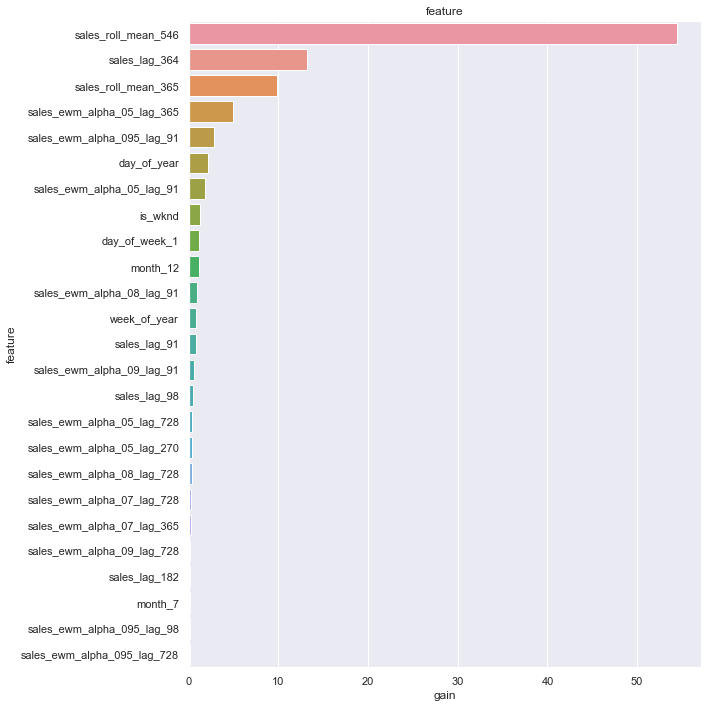

In [80]:
plot_lgb_importances(model, plot=True, num=30)

In [82]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [83]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

### Final Model

In [84]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

In [85]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [86]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [87]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 10.739884 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [94]:
submission_df = test.loc[:, ['id', 'sales', 'date']]

In [95]:
submission_df['sales'] = np.expm1(test_preds)

In [96]:
submission_df['id'] = submission_df.id.astype(int)

In [97]:
submission_df.head()

id      sales       date
0   0  13.323245 2018-01-01
1   1  14.210586 2018-01-02
2   2  14.129583 2018-01-03
3   3  13.746989 2018-01-04
4   4  17.482037 2018-01-05

In [99]:
submission_df.groupby(["date"]) ["sales"].sum()

date
2018-01-01    17030.970587
2018-01-02    19626.393891
2018-01-03    19620.232952
2018-01-04    20858.505680
2018-01-05    22220.846406
                  ...     
2018-03-27    25941.059658
2018-03-28    25953.860651
2018-03-29    27644.166162
2018-03-30    30225.965083
2018-03-31    32233.243434
Name: sales, Length: 90, dtype: float64

In [101]:
dategroup=submission_df.groupby('date').sum()
plt.figure(figsize=(12,5))
dategroup['sales'].plot(x=submission_df.date);